In [ ]:
import pandas as pd
df4=pd.read_csv('/content/drive/MyDrive/AI/df4.csv') #PUBG의 데이터를 불러왔다
print(df4.shape) #df의 행렬크기

(4291447, 32)


In [ ]:
df4=df4.drop('Unnamed: 0',axis=1) #예전 index가 남아있어서 제거

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df4,train_size=0.8,random_state=2) #train test 분리

In [ ]:
train,vali=train_test_split(train,train_size=0.8,random_state=2)#train vali 분리
train.shape,vali.shape,test.shape

((2746525, 31), (686632, 31), (858290, 31))

In [ ]:
target='winPlacePerc'  #target feature 분리
y_train=train[target]
X_train=train.drop(target,axis=1)
y_vali=vali[target]
X_vali=vali.drop(target,axis=1)
y_test=test[target]
X_test=test.drop(target,axis=1)
X_train.shape,X_vali.shape,X_test.shape,y_train.shape,y_vali.shape,y_test.shape

((2746525, 30), (686632, 30), (858290, 30), (2746525,), (686632,), (858290,))

In [ ]:
!pip install category_encoders
!pip install eli5

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
from scipy.stats import randint,uniform

{'class__min_child_weight': 5, 'class__max_depth': 3}  
0.9150702407738683

In [ ]:
y_train.value_counts(normalize=True)

0    0.894997
1    0.105003
Name: winPlacePerc, dtype: float64

In [ ]:
from collections import Counter #model의 가중치 넣는법 
counter = Counter(y_train) 
spw = counter[0] / counter[1]#scale_pos_weight = total_negative_lights / total_pos
spw

8.523549462018842

In [ ]:
pipe=Pipeline([('pre',OrdinalEncoder()),  #name step을 안주니까 parameta에서 읽지를못함
                   ('class',XGBClassifier(
                       base_score=0.894723, #base_score를 넣을수있어서 넣었는데 어떻게변하는지는 잘모르겠습니다                   
                       scale_pos_weight=spw))])

params = {
    'class__n_estimators':randint(100,500), #트리수
    'class__learning_rate':uniform(0.001,0.1),
    'class__min_child_weight': randint(1,5),   
    'class__max_depth': randint(3,10),        
    'class__gamma': randint(0,5),
    'class__subsample': uniform(0.5,1),
    'class__colsample_bytree': uniform(0.5,1),    
    'class__lambda': randint(0,5),
    'class__alpha': randint(0,5)      
    }
randomcv = RandomizedSearchCV(pipe, param_distributions=params, n_iter=13,cv=3,
                                   scoring='roc_auc', n_jobs=-1, verbose=3, random_state=2 )
randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 129.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('pre',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('class',
                                              XGBClassifier(base_score=0.894723,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
        

In [ ]:
#best parameters
print(randomcv.best_params_)

{'class__alpha': 0, 'class__colsample_bytree': 0.6850820781732069, 'class__gamma': 0, 'class__lambda': 3, 'class__learning_rate': 0.04453223926182769, 'class__max_depth': 3, 'class__min_child_weight': 4, 'class__n_estimators': 262, 'class__subsample': 0.6544266730893301}


'class__alpha': 0,  
'class__colsample_bytree': 0.6850820781732069,  
'class__gamma': 0,   
'class__lambda': 3,   
'class__learning_rate': 0.04453223926182769,   
'class__max_depth': 3,   
'class__min_child_weight': 4,   
'class__n_estimators': 262,   
'class__subsample': 0.6544266730893301

In [ ]:
randomcv.best_estimator_

Pipeline(memory=None,
         steps=[('pre',
                 OrdinalEncoder(cols=['groupId', 'matchType'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'groupId',
                                          'data_type': dtype('O'),
                                          'mapping': 9e511a02ddc2e0          1
058d14944a223c          2
3ec7912515c86d          3
3ecffa70c1bb6f          4
5cae0bfa7e60b8          5
                   ...   
4dbb3bb0cea7c9    1585237
8a8d559011eb26    1585238
b6d656d09a0794    1585239
2ae6...
                               colsample_bytree=0.6850820781732069, gamma=0,
                               lambda=3, learning_rate=0.04453223926182769,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=4, missing=None,
                               n_estimators=262, n_jobs

In [ ]:
#score on train set #score=> f1 weighted
print(randomcv.score(X_train,y_train))
#scores on validation set
print(randomcv.score(X_vali,y_vali))

0.9289265393728686
0.928278146894068


'class__colsample_bytree': 0.9026379231331474,  
'class__gamma': 3,  
'class__learning_rate': 0.014516840274511014,  
  'class__max_depth': 4,  
   'class__min_child_weight': 1,  
      'class__n_estimators': 214,  
         'class__subsample': 0.7142428783542877  
train = 0.8488590862579588  
vali = 0.8485969692704555

In [ ]:
y_train_pro=randomcv.predict_proba(X_train)[:,1]
 # proba가 [0의확률,1의확률] 두값이 존재 현재 필요한건 1의값



In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pro)

In [ ]:
roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000e+00,0.000000,1.997572
1,0.000000e+00,0.000003,0.997572
2,0.000000e+00,0.000638,0.994858
3,4.068130e-07,0.000638,0.994857
4,4.068130e-07,0.000759,0.994687
...,...,...,...
543576,9.999927e-01,1.000000,0.003858
543577,9.999951e-01,1.000000,0.003822
543578,9.999955e-01,1.000000,0.003795
543579,9.999980e-01,1.000000,0.003769


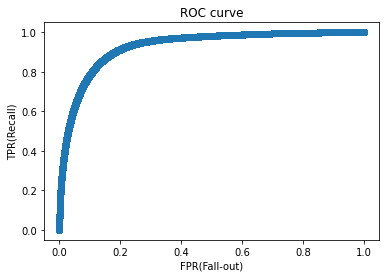

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [ ]:
import numpy as np
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 280142 , threshold: 0.4926057


In [ ]:
from sklearn.metrics import classification_report
y_pred_optimal = y_train_pro >= optimal_threshold
print(classification_report(y_train, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90   2458132
           1       0.38      0.89      0.53    288393

    accuracy                           0.83   2746525
   macro avg       0.68      0.86      0.71   2746525
weighted avg       0.92      0.83      0.86   2746525



In [ ]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_train, y_train_pro)
auc_score #auc score 0.92

0.9289265393728686

In [ ]:
def rocauc(y,y_pre):
    fpr, tpr, thresholds = roc_curve(y, y_pre) #fpr tpr 임계점
    roc = pd.DataFrame({ #시각화를 위한 데이터프레임
        'FPR(Fall-out)': fpr, 
        'TPRate(Recall)': tpr, 
        'Threshold': thresholds
    })
    plt.scatter(fpr, tpr) #점찍음
    plt.title('ROC curve')
    plt.xlabel('FPR(Fall-out)')
    plt.ylabel('TPR(Recall)')

    optimal_idx = np.argmax(tpr - fpr) #tpr-fpr이 최대치가 되는부분을 찾음
    optimal_threshold = thresholds[optimal_idx] #고것이 추천 임계점

    print('idx:', optimal_idx, ', threshold:', optimal_threshold)
    y_pred_optimal = y_pre >= optimal_threshold #임계점보다 높은 값은 True
    print(classification_report(y, y_pred_optimal)) #classification을 보기위해 %=>true false로 바꾼것
    auc_score = roc_auc_score(y, y_pre)
    return print('auc값:',auc_score)

In [ ]:
y_vali_pro=randomcv.predict_proba(X_vali)[:,1]

idx: 280142 , threshold: 0.4926057
              precision    recall  f1-score   support

           0       0.98      0.83      0.90   2458132
           1       0.38      0.89      0.53    288393

    accuracy                           0.83   2746525
   macro avg       0.68      0.86      0.71   2746525
weighted avg       0.92      0.83      0.86   2746525

auc값: 0.9289265393728686


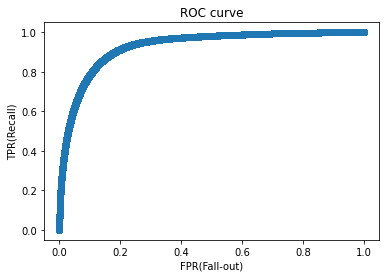

In [ ]:
rocauc(y_train,y_train_pro)

idx: 63407 , threshold: 0.51846004
              precision    recall  f1-score   support

           0       0.98      0.84      0.90    614433
           1       0.39      0.88      0.54     72199

    accuracy                           0.84    686632
   macro avg       0.69      0.86      0.72    686632
weighted avg       0.92      0.84      0.87    686632

auc값: 0.928278146894068


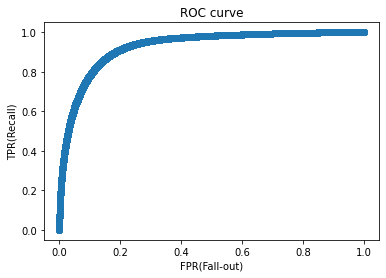

In [ ]:
rocauc(y_vali,y_vali_pro)

In [ ]:
#여기서 한가지 의심드는게 GroupsId가 같으면 똥을싸도 캐리어의 점수를 따라가게된다

In [ ]:
def groupmax(model,X_):
    y_prepro=model.predict_proba(X_)[:,1] #모델의 예측값의 %
    y_prepro=pd.DataFrame(y_prepro)#df로 바꿔줌
    X_ts=X_.reset_index(drop=True)#prepro에 원래 index값이 안남아있어서 합치기위해 리셋인덱스
    X_ts=pd.concat([X_ts['groupId'],y_prepro],axis=1) #groupId와 y_prepro 합침
    X_ts=X_ts.sort_values(by='groupId').reset_index()#groupId순으로 정렬하고 기존 인덱스를 살림
    X_gr=X_ts.groupby('groupId')[0].max().reset_index()#groupId별 예측값의 최대값 groupid 살림
    X_max=pd.merge(X_ts,X_gr,how='left',on='groupId')#합치면서 각 groupId별로 max예측값을 갖게됨
    X_max=X_max.set_index('index').sort_index()#기본에 빼놨던 기본index를 기준으로 정렬
    y_max=X_max['0_y']#예측값만 꺼냄
    return y_max


In [ ]:
y_max=groupmax(randomcv,X_vali)

idx: 78405 , threshold: 0.5356639
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    614433
           1       0.38      0.90      0.54     72199

    accuracy                           0.84    686632
   macro avg       0.68      0.86      0.72    686632
weighted avg       0.92      0.84      0.86    686632

auc값: 0.9329686115564634


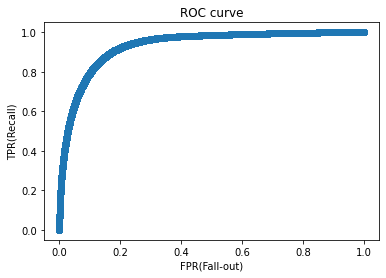

In [ ]:
rocauc(y_vali,y_max)

In [ ]:
xgbfi=randomcv.best_estimator_.named_steps['class'] #randomcv 안에있는 named_steps으로 xgb를 꺼냄

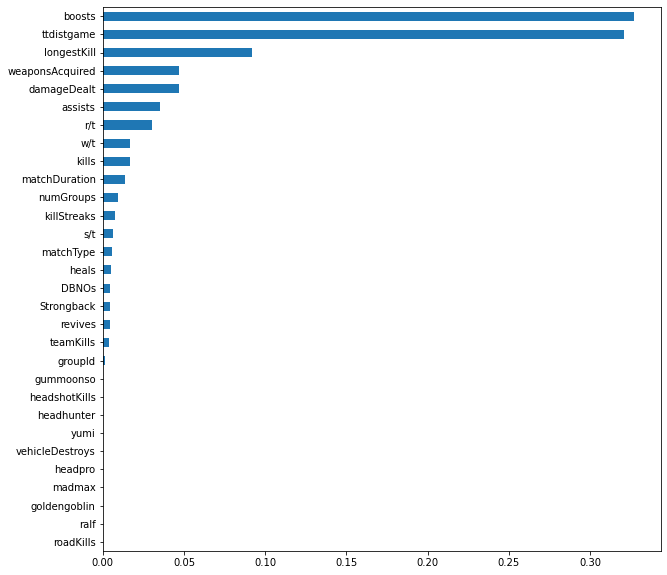

In [ ]:
importances = pd.Series(xgbfi.feature_importances_, X_train.columns) #xgb자체 feature importances
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();

In [ ]:
permuter=PermutationImportance(
    randomcv.best_estimator_.named_steps['class'],
    scoring='f1_weighted',
    n_iter=5,
    random_state=2)


In [ ]:
X_vali_t=randomcv.best_estimator_.named_steps['pre'].transform(X_vali)


In [ ]:
permuter.fit(X_vali_t,y_vali)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(alpha=0, base_score=0.894723,
                                              booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.6850820781732069,
                                              gamma=0, lambda=3,
                                              learning_rate=0.04453223926182769,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=4, missing=None,
                                              n_estimators=262, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                      

In [ ]:
feature_names = X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

boosts            -0.005869
weaponsAcquired   -0.003827
matchDuration     -0.001803
longestKill       -0.001562
s/t               -0.000236
assists           -0.000127
revives           -0.000124
matchType         -0.000029
roadKills          0.000000
ralf               0.000000
gummoonso          0.000000
goldengoblin       0.000000
madmax             0.000000
headpro            0.000000
vehicleDestroys    0.000000
headhunter         0.000000
yumi               0.000000
headshotKills      0.000000
groupId            0.000001
Strongback         0.000032
heals              0.000056
numGroups          0.000058
killStreaks        0.000062
teamKills          0.000178
kills              0.000305
damageDealt        0.000312
DBNOs              0.001595
w/t                0.004624
r/t                0.009995
ttdistgame         0.070585
dtype: float64

In [ ]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
) #xgb기본 feature importances와는 다를걸 예상했지만 이건 달라도 너무달라서 충격적이다 
# ttdistgame는 개인의 이동거리/각 게임당 전인원의 이동거리로 만든것인데 너무 할 정도로 높다...
# 전처리중에 아예 타겟값을 베이스로 만든 피쳐는 없었음.. 

Weight,Feature
0.0706 ± 0.0007,ttdistgame
0.0100 ± 0.0002,r/t
0.0046 ± 0.0001,w/t
0.0016 ± 0.0001,DBNOs
0.0003 ± 0.0001,damageDealt
0.0003 ± 0.0001,kills
0.0002 ± 0.0000,teamKills
0.0001 ± 0.0000,killStreaks
0.0001 ± 0.0001,numGroups
0.0001 ± 0.0000,heals


In [ ]:
pip install shap

     |████████████████████████████████| 356 kB 8.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491643 sha256=3242f1c2ea6cc3637ca6934fc22b2ac47bcb0d5c1b871536be4bd4f26aa8ecef
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import shap

In [ ]:
X_train_t=randomcv.best_estimator_.named_steps['pre'].transform(X_train)

In [ ]:
model=randomcv.best_estimator_.named_steps['class']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_t)

In [ ]:
X_train_t.reset_index()

,index,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,kills,killStreaks,longestKill,matchDuration,matchType,numGroups,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,headpro,w/t,s/t,r/t,ttdistgame,madmax,goldengoblin,gummoonso,ralf,Strongback,yumi,headhunter
0,4121741,1,0,0,0.00,0,0,0,0,0,0.00,1834,1,94,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0
1,743240,2,0,0,0.00,0,0,0,0,0,0.00,1302,2,27,0,0,0,0,3,0.000000,1.000000,0.000000,0.000000,0.001473,0,0,0,0,0,0,0
2,992731,3,0,3,216.40,2,0,2,4,2,48.19,1373,3,27,0,0,0,0,4,0.000000,0.633610,0.000000,0.366390,0.013233,0,0,0,0,0,0,0
3,1261835,4,2,4,137.40,1,2,10,2,1,162.00,1382,2,29,1,0,0,0,5,1.000000,0.812211,0.000000,0.187789,0.030652,0,0,0,0,0,0,0
4,2838279,5,0,0,11.31,0,0,1,0,0,0.00,1954,4,46,0,0,0,0,4,0.000000,1.000000,0.000000,0.000000,0.003836,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746520,3767796,1585238,0,0,239.40,0,0,0,2,1,13.33,1361,1,91,0,0,0,0,2,0.000000,1.000000,0.000000,0.000000,0.000643,0,0,0,0,0,0,0
2746521,3481595,983163,0,1,185.70,0,0,9,0,0,0.00,1834,5,45,1,0,0,0,4,0.000000,1.000000,0.000000,0.000000,0.003317,0,0,0,0,0,0,0
2746522,326683,523542,0,1,79.56,0,0,3,1,1,17.92,1400,2,30,1,0,0,0,3,0.000000,1.000000,0.000000,0.000000,0.016835,0,0,0,0,0,0,0
2746523,2680129,1585239,0,2,299.20,0,1,0,3,1,19.55,1323,5,46,0,0,0,0,4,0.333333,0.845597,0.154403,0.000000,0.018074,0,0,0,0,0,0,0


In [ ]:
X_train_t['ttdistgame'].mean()

0.010549236212100846

In [ ]:
shap.initjs() # (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[719510,:], X_train_t.iloc[719510,:]) #샵과 넣은값에서 첫번쨰 행만 봄

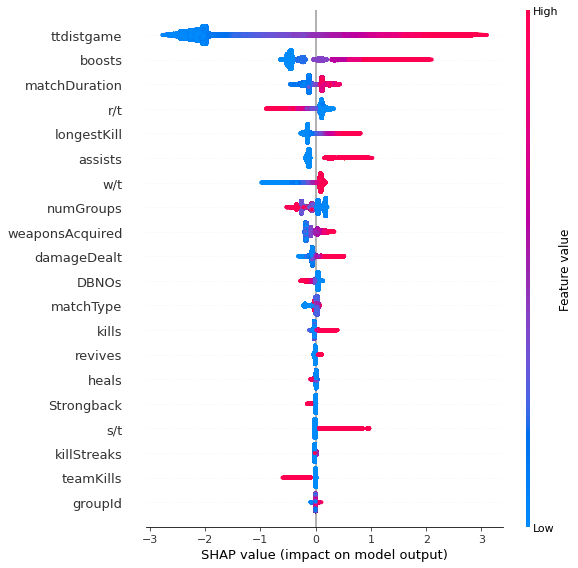

In [ ]:
#summary # 위는 모든 변수들의 shap value를 요약한 것이다. 해당 변수가 빨간색을 띄면 target(price)에 대해 양의 영향력이 존재하는 것이고, 
#파란색을 띄면 음의 영향력이 존재하는 것이다
shap.summary_plot(shap_values, X_train_t)

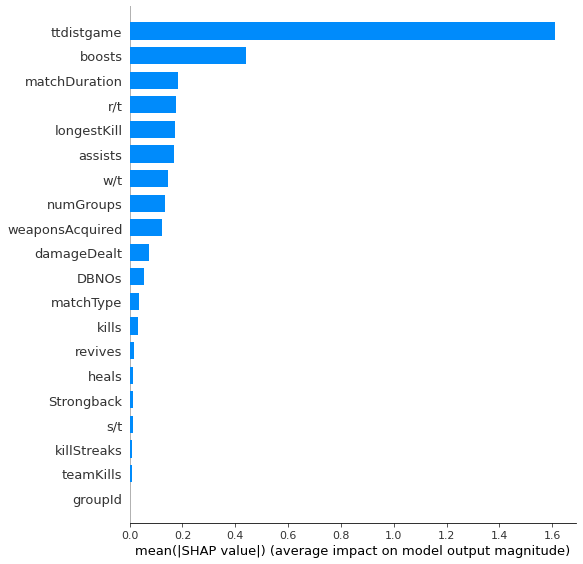

In [ ]:
 #각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, X_train_t, plot_type = "bar")